# Vytvoření datasetu a trénink modelu TFLite

In [ ]:
import os
import tensorflow as tf
import numpy as np
import cv2
import random
import glob

# Cesty
DATA_DIR = '/Volumes/DataHD/Tmp/PythonProjects/Book/TFlite/Dataset/Dice/train'
MODEL_DIR = '/Volumes/DataHD/Tmp/PythonProjects/Book/TFlite/Model'

# Parametry
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 100

# Funkce pro načtení dat
def load_data(data_dir):
    images = []
    bboxes = []

    image_files = glob.glob(os.path.join(data_dir, '*.jpg'))
    for img_path in image_files:
        # Načti obrázek
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, IMG_SIZE)
        img = img / 255.0  # Normalizace

        # Načti bounding boxy
        txt_path = img_path.replace('.jpg', '.txt')
        if os.path.exists(txt_path):
            with open(txt_path, 'r') as f:
                lines = f.readlines()
            boxes = []
            for line in lines:
                parts = line.strip().split()
                if len(parts) == 5:  # class_id x_center y_center width height
                    _, x, y, w, h = map(float, parts)
                    boxes.append([x, y, w, h])
            # Převést na ploché pole - pro jednoduchost max 10 boxů na obrázek
            while len(boxes) < 6:
                boxes.append([0, 0, 0, 0])
            boxes = np.array(boxes[:6]).flatten()  # max 6 objektů
        else:
            boxes = np.zeros(24)  # 6 x 4 = 24 hodnot

        images.append(img)
        bboxes.append(boxes)

    images = np.array(images, dtype=np.float32)
    bboxes = np.array(bboxes, dtype=np.float32)

    return images, bboxes

# Načti data
images, bboxes = load_data(DATA_DIR)

# Rozdělení na trénovací a validační sadu
'''
split_idx = int(0.8 * len(images))
train_images, val_images = images[:split_idx], images[split_idx:]
train_bboxes, val_bboxes = bboxes[:split_idx], bboxes[split_idx:]
'''
train_images = images
train_bboxes = bboxes

# Dataset
'''
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_bboxes)).batch(BATCH_SIZE).shuffle(1000)
val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_bboxes)).batch(BATCH_SIZE)
'''
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_bboxes)).batch(BATCH_SIZE).shuffle(1000)

# Model
'''
def create_model():
    inputs = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    x = tf.keras.layers.Conv2D(32, (3,3), activation='relu')(inputs)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Conv2D(64, (3,3), activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Conv2D(128, (3,3), activation='relu')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    outputs = tf.keras.layers.Dense(24, activation='sigmoid')(x)  # 6 boxů * 4 hodnoty
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model
'''
def create_model():
    inputs = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    x = tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='same')(inputs)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Flatten()(x)  # <<< místo Flatten
    x = tf.keras.layers.Dense(64, activation='relu')(x)  # menší Dense
    outputs = tf.keras.layers.Dense(24, activation='sigmoid')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

model = create_model()
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Callback pro logování metrik
csv_log_path = os.path.join(MODEL_DIR, 'training_log.csv')
csv_logger = tf.keras.callbacks.CSVLogger(csv_log_path, append=False)

# Trénování s callbackem
'''
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[csv_logger]
)
'''
# Trénování bez validačních dat
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    callbacks=[csv_logger]
)

# Uložení TensorFlow modelu
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

tf_model_path = os.path.join(MODEL_DIR, 'dice_detector_tf')
model.save(tf_model_path)

# Převod do TFLite
converter = tf.lite.TFLiteConverter.from_saved_model(tf_model_path)
tflite_model = converter.convert()

tflite_model_path = os.path.join(MODEL_DIR, 'dice_detector.tflite')
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print(f"Model saved to {tf_model_path} and {tflite_model_path}")


# Grafický diagram vrstev

In [16]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers, models, Input
import json

def create_model():
    inputs = Input(shape=(128, 128, 3))
    x = layers.Conv2D(16, (3,3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(24, activation='sigmoid')(x)
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

model = create_model()

# Uložení diagramu modelu do PNG souboru
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

model = create_model()
model_json = model.to_json()

with open("cnn_model_architecture.json", "w") as f:
    f.write(model_json)


# Vykreslení tréninkových metrik

KeyError: 'val_loss'

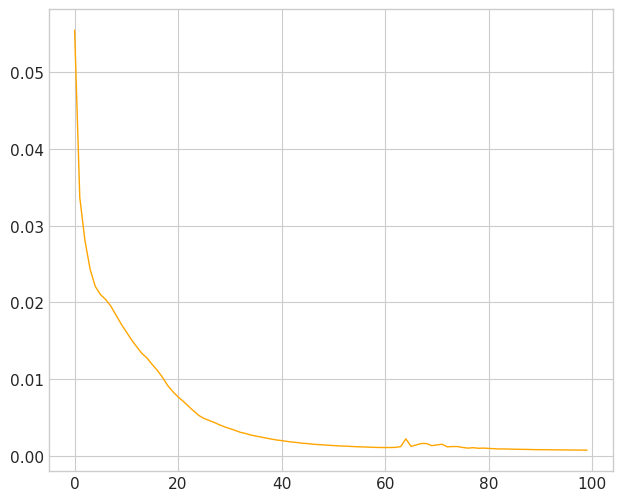

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

# Cesta k souboru CSV
MODEL_DIR = '/Volumes/DataHD/Tmp/PythonProjects/Book/TFlite/Model'
CSV_LOG_PATH = os.path.join(MODEL_DIR, 'training_log.csv')

# Načti logovací CSV
log_df = pd.read_csv(CSV_LOG_PATH)

# Nastavení stylu
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.size': 16,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'legend.fontsize': 12,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'lines.linewidth': 1,
    'font.family': 'DejaVu Sans',
})

# Vykresli grafy
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(log_df['epoch'], log_df['loss'], label='Train Loss', color='orange')
plt.plot(log_df['epoch'], log_df['val_loss'], label='Val Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss during Epoch')
plt.legend(frameon=False)
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(log_df['epoch'], log_df['mae'], label='Train MAE', color='orange')
plt.plot(log_df['epoch'], log_df['val_mae'], label='Val MAE', color='red')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.title('MAE during Epoch')
plt.legend(frameon=False)
plt.grid(alpha=0.3)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# Test modelu 1

Vybere se náhoděný obrázek a zobrazí se bounding boxy kolem detekovaných objektů.


In [ ]:
import os  # Knihovna pro práci se souborovým systémem
import random  # Knihovna pro generování náhodných hodnot
import numpy as np  # Knihovna pro práci s numerickými daty a maticemi
import tensorflow as tf  # Framework pro strojové učení
import cv2  # OpenCV knihovna pro zpracování obrázků
import matplotlib.pyplot as plt  # Knihovna pro vizualizaci dat

# === Cesty ===
DATA_DIR = '/Volumes/DataHD/Tmp/PythonProjects/Book/TFlite/Dataset/Dice/val'  # Cesta k datasetu
MODEL_DIR = '/Volumes/DataHD/Tmp/PythonProjects/Book/TFlite/Model'  # Cesta k modelu
TFLITE_MODEL_PATH = os.path.join(MODEL_DIR, 'dice_detector.tflite')  # Cesta k TFLite modelu

# === Parametry ===
IMG_SIZE = (128, 128)  # Velikost obrázků pro resizing
MAX_OBJECTS = 6  # Maximální počet objektů, které model může detekovat

# === Načtení náhodného obrázku ===
def load_random_image(data_dir):
    image_files = [f for f in os.listdir(data_dir) if f.endswith('.jpg')]  # Načte seznam všech .jpg souborů
    chosen_img = random.choice(image_files)  # Vybere náhodný obrázek
    img_path = os.path.join(data_dir, chosen_img)  # Vytvoří cestu k obrázku
    img = cv2.imread(img_path)  # Načte obrázek pomocí OpenCV
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Převede obrázek z BGR na RGB
    img_resized = cv2.resize(img_rgb, IMG_SIZE)  # Změní velikost obrázku na IMG_SIZE
    img_normalized = img_resized / 255.0  # Normalizuje hodnoty pixelů na rozsah [0, 1]
    return img_rgb, img_normalized[np.newaxis, ...], chosen_img  # Vrací původní obrázek, normalizovaný obrázek a název souboru

# === Načtení anotací ===
def load_annotations(txt_path):
    boxes = []  # Inicializace seznamu pro bounding boxy
    if not os.path.exists(txt_path):  # Kontrola, zda soubor existuje
        return boxes  # Pokud neexistuje, vrátí prázdný seznam
    with open(txt_path, 'r') as f:  # Otevře soubor s anotacemi
        for line in f:  # Pro každý řádek v souboru
            parts = line.strip().split()  # Rozdělí řádek na části
            if len(parts) == 5:  # Kontrola, zda řádek obsahuje 5 hodnot
                _, x, y, w, h = map(float, parts)  # Převede hodnoty na float
                boxes.append([x, y, w, h])  # Přidá bounding box do seznamu
    return boxes  # Vrací seznam bounding boxů

# === Vykreslení boxů ===
def draw_bboxes(img, boxes, color, label=''):
    h, w, _ = img.shape  # Získá výšku a šířku obrázku
    for box in boxes:  # Pro každý bounding box
        x_center, y_center, box_w, box_h = box  # Rozbalí souřadnice boxu
        if box_w < 0.01 or box_h < 0.01:  # Přeskočí boxy s minimální velikostí
            continue
        x1 = int((x_center - box_w / 2) * w)  # Vypočítá levý horní roh
        y1 = int((y_center - box_h / 2) * h)  # Vypočítá levý horní roh
        x2 = int((x_center + box_w / 2) * w)  # Vypočítá pravý dolní roh
        y2 = int((y_center + box_h / 2) * h)  # Vypočítá pravý dolní roh
        cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)  # Vykreslí obdélník na obrázek
        if label:  # Pokud je zadaný popisek
            cv2.putText(img, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)  # Přidá textový popisek
    return img  # Vrací obrázek s vykreslenými boxy

# === Načtení modelu ===
interpreter = tf.lite.Interpreter(model_path=TFLITE_MODEL_PATH)  # Načte TensorFlow Lite model
interpreter.allocate_tensors()  # Alokuje tensory pro model
input_details = interpreter.get_input_details()  # Získá informace o vstupních tensorech
output_details = interpreter.get_output_details()  # Získá informace o výstupních tensorech

# === Inference ===
orig_img, input_img, img_name = load_random_image(DATA_DIR)  # Načte náhodný obrázek
interpreter.set_tensor(input_details[0]['index'], input_img.astype(np.float32))  # Nastaví vstupní data pro model
interpreter.invoke()  # Spustí inferenci
preds = interpreter.get_tensor(output_details[0]['index'])[0]  # Získá predikované bounding boxy
preds = preds.reshape((MAX_OBJECTS, 4))  # Přizpůsobí výstup na formát (MAX_OBJECTS, 4)

# === Načtení anotací (GT) ===
annotation_path = os.path.join(DATA_DIR, img_name.replace('.jpg', '.txt'))  # Vytvoří cestu k souboru s anotacemi
gt_boxes = load_annotations(annotation_path)  # Načte skutečné bounding boxy

# === Vykresli: zeleně predikce, červeně GT ===
img_vis = orig_img.copy()  # Vytvoří kopii původního obrázku
img_vis = draw_bboxes(img_vis, preds, color=(0, 255, 0), label='Pred')  # Vykreslí predikované boxy zeleně
img_vis = draw_bboxes(img_vis, gt_boxes, color=(255, 0, 0), label='GT')  # Vykreslí skutečné boxy červeně

# === Zobraz ===
plt.figure(figsize=(8, 8))  # Nastaví velikost obrázku
plt.imshow(img_vis)  # Zobrazí obrázek
plt.title(f'Predikce (zeleně) vs. GT (červeně): {img_name}')  # Přidá titulek
plt.axis('off')  # Skryje osy
plt.show()  # Zobrazí výsledek

# Test modelu 2

Výpočet průměrné MAE, IoU a zobrazení náhodně vybraného obrázku se zeleně detekovanými boxy a červenými boxy anotace.

In [ ]:
import os
import random
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt

# === Cesty ===
DATA_DIR = '/Volumes/DataHD/Tmp/PythonProjects/Book/TFlite/Dataset/Dice/val'
MODEL_DIR = '/Volumes/DataHD/Tmp/PythonProjects/Book/TFlite/Model'
TFLITE_MODEL_PATH = os.path.join(MODEL_DIR, 'dice_detector.tflite')

# === Parametry ===
IMG_SIZE = (128, 128)
MAX_OBJECTS = 6

# === Načtení náhodného obrázku ===
def load_random_image(data_dir):
    image_files = [f for f in os.listdir(data_dir) if f.endswith('.jpg')]
    chosen_img = random.choice(image_files)
    img_path = os.path.join(data_dir, chosen_img)
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, IMG_SIZE)
    img_normalized = img_resized / 255.0
    return img_rgb, img_normalized[np.newaxis, ...], chosen_img

# === Načtení anotací ===
def load_annotations(txt_path):
    boxes = []
    if not os.path.exists(txt_path):
        return boxes
    with open(txt_path, 'r') as f:
        for line in f.readlines():
            parts = line.strip().split()
            if len(parts) == 5:
                _, x, y, w, h = map(float, parts)
                boxes.append([x, y, w, h])
    return boxes

# === Vykreslení bounding boxů ===
def draw_bboxes(img, boxes, color, label=''):
    h, w, _ = img.shape
    for box in boxes:
        x_center, y_center, box_w, box_h = box
        if box_w < 0.01 or box_h < 0.01:
            continue
        x1 = int(max((x_center - box_w / 2) * w, 0))
        y1 = int(max((y_center - box_h / 2) * h, 0))
        x2 = int(min((x_center + box_w / 2) * w, w - 1))
        y2 = int(min((y_center + box_h / 2) * h, h - 1))
        cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
        if label:
            cv2.putText(img, label, (x1, y1 - 4), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
    return img

# === Výpočet IoU ===
def compute_iou(boxA, boxB):
    xa, ya, wa, ha = boxA
    xb, yb, wb, hb = boxB

    xa1 = xa - wa / 2
    ya1 = ya - ha / 2
    xa2 = xa + wa / 2
    ya2 = ya + ha / 2

    xb1 = xb - wb / 2
    yb1 = yb - hb / 2
    xb2 = xb + wb / 2
    yb2 = yb + hb / 2

    xi1 = max(xa1, xb1)
    yi1 = max(ya1, yb1)
    xi2 = min(xa2, xb2)
    yi2 = min(ya2, yb2)

    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    union_area = wa * ha + wb * hb - inter_area

    return inter_area / union_area if union_area > 0 else 0

# === Načtení TFLite FLOAT32 modelu ===
interpreter = tf.lite.Interpreter(model_path=TFLITE_MODEL_PATH)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# === Načtení obrázku ===
orig_img, input_img, img_name = load_random_image(DATA_DIR)

# === Inference ===
interpreter.set_tensor(input_details[0]['index'], input_img.astype(np.float32))
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])
preds = output_data.reshape((MAX_OBJECTS, 4))

# === Načtení anotací (GT) ===
annotation_path = os.path.join(DATA_DIR, img_name.replace('.jpg', '.txt'))
gt_boxes = load_annotations(annotation_path)

# === Výpočet metrik ===
mae_total = 0
iou_total = 0
count = 0
for i, gt in enumerate(gt_boxes):
    if i >= MAX_OBJECTS:
        break
    pred = preds[i]
    mae = np.abs(np.array(gt) - pred).mean()
    iou = compute_iou(gt, pred)
    mae_total += mae
    iou_total += iou
    count += 1

if count > 0:
    avg_mae = mae_total / count
    avg_iou = iou_total / count
    print(f"\n📊 MAE (Mean Absolute Error): {avg_mae:.4f}")
    print(f"📐 IoU (Intersection over Union): {avg_iou:.4f}")
else:
    print("⚠️  Nebyly nalezeny žádné anotace pro výpočet metrik.")

# === Vykreslení predikce + GT ===
img_vis = orig_img.copy()
img_vis = draw_bboxes(img_vis, preds, (0, 255, 0), 'Pred')
img_vis = draw_bboxes(img_vis, gt_boxes, (255, 0, 0), 'GT')

plt.figure(figsize=(8, 8))
plt.imshow(img_vis)
plt.title(f'FLOAT32 Predikce vs. GT: {img_name}')
plt.axis('off')
plt.show()


# Test modelu 3

Zobrazenmí matice 9-ti náhodně vybraných obrázků s vznyčením dtekovaných objektů s jejich anotacemi.

In [ ]:
import os
import random
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt

# Cesty
DATA_DIR = '/Volumes/DataHD/Tmp/PythonProjects/Book/TFlite/Dataset/Dice/val'
MODEL_DIR = '/Volumes/DataHD/Tmp/PythonProjects/Book/TFlite/Model'
TFLITE_MODEL_PATH = os.path.join(MODEL_DIR, 'dice_detector.tflite')

# Parametry
IMG_SIZE = (128, 128)
MAX_OBJECTS = 6
NUM_EXAMPLES = 9

# === Načtení anotací ===
def load_annotations(txt_path):
    boxes = []
    if not os.path.exists(txt_path):
        return boxes
    with open(txt_path, 'r') as f:
        for line in f.readlines():
            parts = line.strip().split()
            if len(parts) == 5:
                _, x, y, w, h = map(float, parts)
                boxes.append([x, y, w, h])
    return boxes

# === Vykreslení boxů ===
def draw_bboxes(img, boxes, color, label=''):
    h, w, _ = img.shape
    for i in range(len(boxes)):
        x_center, y_center, box_w, box_h = boxes[i]
        if box_w < 0.01 or box_h < 0.01:
            continue
        x1 = int((x_center - box_w / 2) * w)
        y1 = int((y_center - box_h / 2) * h)
        x2 = int((x_center + box_w / 2) * w)
        y2 = int((y_center + box_h / 2) * h)
        cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
        if label:
            cv2.putText(img, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
    return img

# === Výpočet IoU ===
def compute_iou(boxA, boxB):
    xa1, ya1, wa, ha = boxA
    xb1, yb1, wb, hb = boxB

    xa1 -= wa / 2
    ya1 -= ha / 2
    xa2 = xa1 + wa
    ya2 = ya1 + ha

    xb1 -= wb / 2
    yb1 -= hb / 2
    xb2 = xb1 + wb
    yb2 = yb1 + hb

    xi1 = max(xa1, xb1)
    yi1 = max(ya1, yb1)
    xi2 = min(xa2, xb2)
    yi2 = min(ya2, yb2)

    inter_width = max(0, xi2 - xi1)
    inter_height = max(0, yi2 - yi1)
    inter_area = inter_width * inter_height

    area_a = wa * ha
    area_b = wb * hb
    union_area = area_a + area_b - inter_area

    return inter_area / union_area if union_area > 0 else 0

# === Načtení modelu ===
interpreter = tf.lite.Interpreter(model_path=TFLITE_MODEL_PATH)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# === Hromadné vyhodnocení ===
image_files = sorted([f for f in os.listdir(DATA_DIR) if f.endswith('.jpg')])
total_mae = 0
total_iou = 0
total_count = 0
samples_with_gt = []

for img_file in image_files:
    txt_file = img_file.replace('.jpg', '.txt')
    txt_path = os.path.join(DATA_DIR, txt_file)
    if not os.path.exists(txt_path):
        continue

    img_path = os.path.join(DATA_DIR, img_file)
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, IMG_SIZE)
    img_input = img_resized / 255.0
    input_tensor = np.expand_dims(img_input, axis=0).astype(np.float32)

    interpreter.set_tensor(input_details[0]['index'], input_tensor)
    interpreter.invoke()
    preds = interpreter.get_tensor(output_details[0]['index'])[0]
    preds = preds.reshape((MAX_OBJECTS, 4))

    gt_boxes = load_annotations(txt_path)

    for i, gt in enumerate(gt_boxes):
        if i >= MAX_OBJECTS:
            break
        mae = np.abs(np.array(gt) - preds[i]).mean()
        iou = compute_iou(gt, preds[i])
        total_mae += mae
        total_iou += iou
        total_count += 1

    if len(samples_with_gt) < NUM_EXAMPLES:
        samples_with_gt.append((img_rgb.copy(), preds, gt_boxes, img_file))

# === Výsledek ===
if total_count > 0:
    avg_mae = total_mae / total_count
    avg_iou = total_iou / total_count
    print(f"\n📊 Průměrná MAE pro celý dataset: {avg_mae:.4f}")
    print(f"📐 Průměrné IoU pro celý dataset: {avg_iou:.4f}")
else:
    print("❗️Nebyla nalezena žádná anotace pro vyhodnocení.")

# === Zobrazení několika příkladů ===
cols = 3
rows = int(np.ceil(len(samples_with_gt) / cols))
fig, axs = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))

for i, (img, preds, gts, name) in enumerate(samples_with_gt):
    vis = draw_bboxes(img.copy(), preds, (0, 255, 0), 'Pred')
    vis = draw_bboxes(vis, gts, (255, 0, 0), 'GT')
    ax = axs[i // cols, i % cols] if rows > 1 else axs[i]
    ax.imshow(vis)
    ax.set_title(name)
    ax.axis('off')

# Skryj prázdné subplots, pokud nejsou zaplněné
for j in range(len(samples_with_gt), rows * cols):
    ax = axs[j // cols, j % cols] if rows > 1 else axs[j]
    ax.axis('off')

plt.tight_layout()
plt.show()


# Kvantizace modelu TFLite na int8


In [ ]:
import tensorflow as tf
import numpy as np
import os
import cv2
import random
import glob

# Cesty
MODEL_DIR = '/Volumes/DataHD/Tmp/PythonProjects/Book/TFlite/Model'
DATA_DIR = '/Volumes/DataHD/Tmp/PythonProjects/Book/TFlite/Dataset/Dice'

# Parametry
IMG_SIZE = (128, 128)
SAMPLES_FOR_CALIBRATION = 100

# Dataset pro kalibraci
def representative_dataset_gen():
    image_paths = glob.glob(os.path.join(DATA_DIR, '*.jpg'))
    for path in random.sample(image_paths, min(len(image_paths), SAMPLES_FOR_CALIBRATION)):
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, IMG_SIZE)
        img = img / 255.0
        img = np.expand_dims(img.astype(np.float32), axis=0)
        yield [img]

# Načti model
model = tf.keras.models.load_model(os.path.join(MODEL_DIR, 'dice_detector_tf'))

# Převodce
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

# INT8 vstup/výstup
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

# Převod
tflite_model = converter.convert()

# Uložení
quant_path = os.path.join(MODEL_DIR, 'dice_detector_int8.tflite')
with open(quant_path, 'wb') as f:
    f.write(tflite_model)

print(f"✅ INT8 kvantizovaný model uložen do: {quant_path}")


# Test kvantizovaného modelu int8

In [ ]:
import os
import random
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import tensorflow as tf

# Cesty
DATA_DIR = '/Volumes/DataHD/Tmp/PythonProjects/Book/TFlite/Dataset/Dice/val'
MODEL_DIR = '/Volumes/DataHD/Tmp/PythonProjects/Book/TFlite/Model'
TFLITE_MODEL_PATH = os.path.join(MODEL_DIR, 'dice_detector_int8.tflite')

# Parametry
IMG_SIZE = (128, 128)
MAX_OBJECTS = 6

# Funkce pro načtení náhodného obrázku
def load_random_image(data_dir):
    image_files = [f for f in os.listdir(data_dir) if f.endswith('.jpg')]
    chosen_img = random.choice(image_files)
    img_path = os.path.join(data_dir, chosen_img)
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, IMG_SIZE)
    img_normalized = img_resized / 255.0
    return img, img_normalized[np.newaxis, ...], chosen_img

# Funkce pro vykreslení bounding boxů
def draw_bboxes(img, preds, color=(0, 255, 0), thickness=2):
    h, w, _ = img.shape
    for i in range(MAX_OBJECTS):
        x_center, y_center, box_w, box_h = preds[i]

        if box_w < 0.01 or box_h < 0.01:
            continue

        x_center_px = x_center * w
        y_center_px = y_center * h
        box_w_px = box_w * w
        box_h_px = box_h * h

        x1 = int(max(x_center_px - box_w_px / 2, 0))
        y1 = int(max(y_center_px - box_h_px / 2, 0))
        x2 = int(min(x_center_px + box_w_px / 2, w - 1))
        y2 = int(min(y_center_px + box_h_px / 2, h - 1))

        cv2.rectangle(img, (x1, y1), (x2, y2), color, thickness)

    return img

# Načtení TFLite modelu
interpreter = tf.lite.Interpreter(model_path=TFLITE_MODEL_PATH)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Získání rozsahu kvantizace
input_scale, input_zero_point = input_details[0]['quantization']
output_scale, output_zero_point = output_details[0]['quantization']

# Načti náhodný obrázek
orig_img, input_img, img_name = load_random_image(DATA_DIR)

# Kvantizace vstupu
input_img = (input_img / input_scale + input_zero_point).astype(np.int8)

# Infernece
interpreter.set_tensor(input_details[0]['index'], input_img)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])

# De-kvantizace výstupu
preds = (output_data.astype(np.float32) - output_zero_point) * output_scale
preds = preds.reshape((MAX_OBJECTS, 4))

# Vykresli bounding boxy
img_with_boxes = draw_bboxes(orig_img.copy(), preds)

# Zobraz obrázek
plt.figure(figsize=(8, 8))
plt.imshow(img_with_boxes)
plt.title(f"Prediction for: {img_name}")
plt.axis('off')
plt.show()


# Test kvant. modelu 2

Výpočet  MAE, IoU a zobrazení náhodně vybraného obrázku se zeleně detekovanými boxy a červenými boxy anotace.

In [ ]:
import os
import random
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import tensorflow as tf

# === Cesty ===
DATA_DIR = '/Volumes/DataHD/Tmp/PythonProjects/Book/TFlite/Dataset/Dice/val'
MODEL_DIR = '/Volumes/DataHD/Tmp/PythonProjects/Book/TFlite/Model'
TFLITE_MODEL_PATH = os.path.join(MODEL_DIR, 'dice_detector_int8.tflite')

# === Parametry ===
IMG_SIZE = (128, 128)
MAX_OBJECTS = 6

# === Načtení náhodného obrázku ===
def load_random_image(data_dir):
    image_files = [f for f in os.listdir(data_dir) if f.endswith('.jpg')]
    chosen_img = random.choice(image_files)
    img_path = os.path.join(data_dir, chosen_img)
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, IMG_SIZE)
    img_normalized = img_resized / 255.0
    return img_rgb, img_normalized[np.newaxis, ...], chosen_img

# === Načtení anotací ===
def load_annotations(txt_path):
    boxes = []
    if not os.path.exists(txt_path):
        return boxes
    with open(txt_path, 'r') as f:
        for line in f.readlines():
            parts = line.strip().split()
            if len(parts) == 5:
                _, x, y, w, h = map(float, parts)
                boxes.append([x, y, w, h])
    return boxes

# === Vykreslení bounding boxů ===
def draw_bboxes(img, boxes, color, label=''):
    h, w, _ = img.shape
    for box in boxes:
        x_center, y_center, box_w, box_h = box
        if box_w < 0.01 or box_h < 0.01:
            continue
        x1 = int(max((x_center - box_w / 2) * w, 0))
        y1 = int(max((y_center - box_h / 2) * h, 0))
        x2 = int(min((x_center + box_w / 2) * w, w - 1))
        y2 = int(min((y_center + box_h / 2) * h, h - 1))
        cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
        if label:
            cv2.putText(img, label, (x1, y1 - 4), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
    return img

# === Výpočet IoU ===
def compute_iou(boxA, boxB):
    xa, ya, wa, ha = boxA
    xb, yb, wb, hb = boxB

    xa1 = xa - wa / 2
    ya1 = ya - ha / 2
    xa2 = xa + wa / 2
    ya2 = ya + ha / 2

    xb1 = xb - wb / 2
    yb1 = yb - hb / 2
    xb2 = xb + wb / 2
    yb2 = yb + hb / 2

    xi1 = max(xa1, xb1)
    yi1 = max(ya1, yb1)
    xi2 = min(xa2, xb2)
    yi2 = min(ya2, yb2)

    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    union_area = wa * ha + wb * hb - inter_area

    return inter_area / union_area if union_area > 0 else 0

# === Načtení TFLite INT8 modelu ===
interpreter = tf.lite.Interpreter(model_path=TFLITE_MODEL_PATH)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_scale, input_zero_point = input_details[0]['quantization']
output_scale, output_zero_point = output_details[0]['quantization']

# === Načtení obrázku ===
orig_img, input_img, img_name = load_random_image(DATA_DIR)

# === Kvantizace vstupu ===
input_img_q = (input_img / input_scale + input_zero_point).astype(np.int8)

# === Inference ===
interpreter.set_tensor(input_details[0]['index'], input_img_q)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])

# === Dekvantizace výstupu ===
preds = (output_data.astype(np.float32) - output_zero_point) * output_scale
preds = preds.reshape((MAX_OBJECTS, 4))

# === Načtení anotací (GT) ===
annotation_path = os.path.join(DATA_DIR, img_name.replace('.jpg', '.txt'))
gt_boxes = load_annotations(annotation_path)

# === Výpočet metrik ===
mae_total = 0
iou_total = 0
count = 0
for i, gt in enumerate(gt_boxes):
    if i >= MAX_OBJECTS:
        break
    pred = preds[i]
    mae = np.abs(np.array(gt) - pred).mean()
    iou = compute_iou(gt, pred)
    mae_total += mae
    iou_total += iou
    count += 1

if count > 0:
    avg_mae = mae_total / count
    avg_iou = iou_total / count
    print(f"\n📊 MAE (Mean Absolute Error): {avg_mae:.4f}")
    print(f"📐 IoU (Intersection over Union): {avg_iou:.4f}")
else:
    print("⚠️  Nebyly nalezeny žádné anotace pro výpočet metrik.")

# === Vykreslení predikce + GT ===
img_vis = orig_img.copy()
img_vis = draw_bboxes(img_vis, preds, (0, 255, 0), 'Pred')
img_vis = draw_bboxes(img_vis, gt_boxes, (255, 0, 0), 'GT')

plt.figure(figsize=(8, 8))
plt.imshow(img_vis)
plt.title(f'INT8 Predikce vs. GT: {img_name}')
plt.axis('off')

plt.show()


# Test kvant modelu 3

Výpočet průměrné MAE, IoU a zobrazení náhodně vybraného obrázku se zeleně detekovanými boxy a červenými boxy anotace.

In [ ]:
import os
import random
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import tensorflow as tf

# === Cesty ===
DATA_DIR = '/Volumes/DataHD/Tmp/PythonProjects/Book/TFlite/Dataset/Dice/val'
MODEL_DIR = '/Volumes/DataHD/Tmp/PythonProjects/Book/TFlite/Model'
TFLITE_MODEL_PATH = os.path.join(MODEL_DIR, 'dice_detector_int8.tflite')

# === Parametry ===
IMG_SIZE = (128, 128)
MAX_OBJECTS = 6
NUM_EXAMPLES = 9

# === Funkce pro načtení anotací ===
def load_annotations(txt_path):
    boxes = []
    if not os.path.exists(txt_path):
        return boxes
    with open(txt_path, 'r') as f:
        for line in f.readlines():
            parts = line.strip().split()
            if len(parts) == 5:
                _, x, y, w, h = map(float, parts)
                boxes.append([x, y, w, h])
    return boxes

# === Funkce pro vykreslení boxů ===
def draw_bboxes(img, boxes, color, label=''):
    h, w, _ = img.shape
    for box in boxes:
        x_center, y_center, box_w, box_h = box
        if box_w < 0.01 or box_h < 0.01:
            continue
        x1 = int(max((x_center - box_w / 2) * w, 0))
        y1 = int(max((y_center - box_h / 2) * h, 0))
        x2 = int(min((x_center + box_w / 2) * w, w - 1))
        y2 = int(min((y_center + box_h / 2) * h, h - 1))
        cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
        if label:
            cv2.putText(img, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, color, 1)
    return img

# === Výpočet IoU ===
def compute_iou(boxA, boxB):
    xa1, ya1, wa, ha = boxA
    xb1, yb1, wb, hb = boxB

    xa1 -= wa / 2
    ya1 -= ha / 2
    xa2 = xa1 + wa
    ya2 = ya1 + ha

    xb1 -= wb / 2
    yb1 -= hb / 2
    xb2 = xb1 + wb
    yb2 = yb1 + hb

    xi1 = max(xa1, xb1)
    yi1 = max(ya1, yb1)
    xi2 = min(xa2, xb2)
    yi2 = min(ya2, yb2)

    inter_width = max(0, xi2 - xi1)
    inter_height = max(0, yi2 - yi1)
    inter_area = inter_width * inter_height

    area_a = wa * ha
    area_b = wb * hb
    union_area = area_a + area_b - inter_area

    return inter_area / union_area if union_area > 0 else 0

# === Načtení modelu ===
interpreter = tf.lite.Interpreter(model_path=TFLITE_MODEL_PATH)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
input_scale, input_zero_point = input_details[0]['quantization']
output_scale, output_zero_point = output_details[0]['quantization']

# === Vyhodnocení přes celý dataset ===
image_files = sorted([f for f in os.listdir(DATA_DIR) if f.endswith('.jpg')])
total_mae = 0
total_iou = 0
total_count = 0
samples = []

for img_file in image_files:
    txt_file = img_file.replace('.jpg', '.txt')
    txt_path = os.path.join(DATA_DIR, txt_file)
    if not os.path.exists(txt_path):
        continue

    img_path = os.path.join(DATA_DIR, img_file)
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, IMG_SIZE)
    img_normalized = img_resized / 255.0
    input_tensor = (img_normalized / input_scale + input_zero_point).astype(np.int8)[np.newaxis, ...]

    interpreter.set_tensor(input_details[0]['index'], input_tensor)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    preds = (output_data.astype(np.float32) - output_zero_point) * output_scale
    preds = preds.reshape((MAX_OBJECTS, 4))

    gt_boxes = load_annotations(txt_path)

    for i, gt in enumerate(gt_boxes):
        if i >= MAX_OBJECTS:
            break
        mae = np.abs(np.array(gt) - preds[i]).mean()
        iou = compute_iou(gt, preds[i])
        total_mae += mae
        total_iou += iou
        total_count += 1

    if len(samples) < NUM_EXAMPLES:
        vis_img = draw_bboxes(img_rgb.copy(), preds, (0, 255, 0), 'Pred')
        vis_img = draw_bboxes(vis_img, gt_boxes, (255, 0, 0), 'GT')
        samples.append((vis_img, img_file))

# === Výpis metrik ===
if total_count > 0:
    avg_mae = total_mae / total_count
    avg_iou = total_iou / total_count
    print(f"\n📊 Průměrná MAE pro celý dataset: {avg_mae:.4f}")
    print(f"📐 Průměrné IoU pro celý dataset: {avg_iou:.4f}")
else:
    print("⚠️ Nebyla nalezena žádná anotace pro výpočet metrik.")

# === Zobrazení 3×3 obrázků ===
fig, axs = plt.subplots(3, 3, figsize=(12, 12))
for i, (img, name) in enumerate(samples):
    ax = axs[i // 3, i % 3]
    ax.imshow(img)
    ax.set_title(name)
    ax.axis('off')

# Skryj prázdné buňky
for j in range(len(samples), 9):
    axs[j // 3, j % 3].axis('off')

plt.tight_layout()
plt.show()


# Porovnání modelů před a po kvantizaci

## Velikost modelu (Size)

- Kvantizovaný model (INT8) je typicky 4× menší než model v float32.
- Porovnání: velikost souboru .tflite před a po kvantizaci.



In [ ]:
modelPath = os.path.join(MODEL_DIR, 'dice_detector.tflite')
modelPathQ = os.path.join(MODEL_DIR, 'dice_detector_int8.tflite')
size_fp32 = os.path.getsize(modelPath)
size_int8 = os.path.getsize(modelPathQ)

print(f"Velikost FP32 modelu: {size_fp32 / 1024:.2f} KB")
print(f"Velikost INT8 modelu: {size_int8 / 1024:.2f} KB")

# Převod na C++ pole

In [ ]:
import os

# Cesty
MODEL_PATH = '/Volumes/DataHD/Tmp/PythonProjects/Book/TFlite/Model/dice_detector.tflite'
HEADER_PATH = '/Volumes/DataHD/Tmp/PythonProjects/Book/TFlite/Model/dice_detector_model.h'

# Název proměnné
ARRAY_NAME = "dice_detector_model"

# Načtení modelu jako bajty
with open(MODEL_PATH, 'rb') as f:
    model_bytes = f.read()

# Vytvoření pole jako hex hodnot
hex_array = ',\n  '.join(f'0x{byte:02x}' for byte in model_bytes)

# Sestavení C++ hlavičkového souboru
header_content = f"""\
#ifndef DICE_DETECTOR_MODEL_H
#define DICE_DETECTOR_MODEL_H

// Tento soubor byl vygenerován automaticky z TFLite modelu
const unsigned char {ARRAY_NAME}[] = {{
  {hex_array}
}};

const int {ARRAY_NAME}_len = {len(model_bytes)};

#endif // DICE_DETECTOR_MODEL_H
"""

# Uložení do souboru
with open(HEADER_PATH, 'w') as f:
    f.write(header_content)

print(f"✅ Header file saved to: {HEADER_PATH}")


# Vytvoření modelu pro FOMO detektor

In [ ]:
import os
import glob
import random
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.callbacks import CSVLogger

# Cesty
DATA_DIR = '/Volumes/DataHD/Tmp/PythonProjects/Book/TFlite/Dataset/Dice/train'
MODEL_DIR = '/Volumes/DataHD/Tmp/PythonProjects/Book/TFlite/Model'

# Parametry
IMG_SIZE = (128, 128)
GRID_SIZE = (16, 16)  # FOMO grid
CELL_WIDTH = IMG_SIZE[0] // GRID_SIZE[0]
CELL_HEIGHT = IMG_SIZE[1] // GRID_SIZE[1]
BATCH_SIZE = 32
EPOCHS = 50
SAMPLES_FOR_CALIBRATION = 100

# Funkce na načtení dat
def load_fomo_data(data_dir):
    images = []
    target_grids = []

    image_files = glob.glob(os.path.join(data_dir, '*.jpg'))

    for img_path in image_files:
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, IMG_SIZE)
        img = img / 255.0

        # Inicializuj target grid
        grid = np.zeros(GRID_SIZE, dtype=np.float32)

        # Načti bounding boxy
        txt_path = img_path.replace('.jpg', '.txt')
        if os.path.exists(txt_path):
            with open(txt_path, 'r') as f:
                lines = f.readlines()
            for line in lines:
                parts = line.strip().split()
                if len(parts) == 5:
                    _, x_center, y_center, width, height = map(float, parts)
                    # Převést normalizované souřadnice do pixelů
                    x_pixel = int(x_center * IMG_SIZE[0])
                    y_pixel = int(y_center * IMG_SIZE[1])

                    # Najít odpovídající buňku
                    grid_x = min(x_pixel // CELL_WIDTH, GRID_SIZE[0] - 1)
                    grid_y = min(y_pixel // CELL_HEIGHT, GRID_SIZE[1] - 1)

                    # Označit buňku jako obsahující objekt
                    for dy in [-1, 0, 1]:
                        for dx in [-1, 0, 1]:
                            gx = grid_x + dx
                            gy = grid_y + dy
                            if 0 <= gx < GRID_SIZE[0] and 0 <= gy < GRID_SIZE[1]:
                                grid[gy, gx] = max(grid[gy, gx], 0.5 if (dx != 0 or dy != 0) else 0.9)

        images.append(img)
        target_grids.append(grid[..., np.newaxis])  # přidat kanál

    return np.array(images, dtype=np.float32), np.array(target_grids, dtype=np.float32)

# Nahrání dat

images, grids = load_fomo_data(DATA_DIR)
print(f"Dataset loaded: {images.shape} images, {grids.shape} grids")

# Rozdělení na train/val
'''
split_idx = int(0.8 * len(images))
train_images, val_images = images[:split_idx], images[split_idx:]
train_grids, val_grids = grids[:split_idx], grids[split_idx:]
'''
train_images = images
train_grids = grids

'''
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_grids)).shuffle(500).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_grids)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
'''
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_grids)).shuffle(500).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Model
def create_fomo_model():
    inputs = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    x = tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='same')(inputs)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = tf.keras.layers.Conv2D(1, (1,1), activation='sigmoid')(x)
    x = tf.keras.layers.Resizing(GRID_SIZE[0], GRID_SIZE[1])(x)
    model = tf.keras.Model(inputs=inputs, outputs=x)
    return model

model = create_fomo_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Připrav CSV Logger
csv_log_path = os.path.join(MODEL_DIR, 'fomo_training_log.csv')
csv_logger = CSVLogger(csv_log_path)

# Trénování
'''
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[csv_logger]  # přidáno logování metrik
)
'''
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    callbacks=[csv_logger]  # přidáno logování metrik
)

# Uložení TensorFlow modelu
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

tf_model_path = os.path.join(MODEL_DIR, 'fomo_detector_tf')
model.save(tf_model_path)
print(f"FOMO-like TensorFlow model uložen do: {tf_model_path}")

# Převod do TFLite
converter = tf.lite.TFLiteConverter.from_saved_model(tf_model_path)
tflite_model = converter.convert()

tflite_model_path = os.path.join(MODEL_DIR, 'fomo_detector.tflite')
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print(f"Model saved to {tf_model_path} and {tflite_model_path}")

# Kvantizace na INT8
def representative_dataset():
    for i in range(min(SAMPLES_FOR_CALIBRATION, len(train_images))):
        img = train_images[i]
        img = np.expand_dims(img, axis=0)
        yield [img]

converter = tf.lite.TFLiteConverter.from_saved_model(tf_model_path)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

tflite_model = converter.convert()

# Ulozeni kvantizovaného modelu
quant_model_path = os.path.join(MODEL_DIR, 'fomo_detector_int8.tflite')
model.trainable = False
with open(quant_model_path, 'wb') as f:
    f.write(tflite_model)

print(f"Kvantizovaný INT8 model uložen do: {quant_model_path}")


# Testování kvantizovaného modelu FOMO


In [70]:
import os
import glob
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.ndimage import maximum_filter

# Cesty
DATA_DIR = '/Volumes/DataHD/Tmp/PythonProjects/Book/TFlite/Dataset/Dice/val'
MODEL_DIR = '/Volumes/DataHD/Tmp/PythonProjects/Book/TFlite/Model'

# Parametry
IMG_SIZE = (128, 128)
GRID_SIZE = (16, 16)
CELL_WIDTH = IMG_SIZE[0] // GRID_SIZE[0]
CELL_HEIGHT = IMG_SIZE[1] // GRID_SIZE[1]
THRESHOLD = 0.35
NMS_SIZE = 3  # okolí pro maximální filtr

# Načti model
model = tf.keras.models.load_model(os.path.join(MODEL_DIR, 'fomo_detector_tf'))

# Funkce na výběr náhodného obrázku
def load_random_image():
    image_files = glob.glob(os.path.join(DATA_DIR, '*.jpg'))
    img_path = np.random.choice(image_files)
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, IMG_SIZE) / 255.0
    return img_rgb, np.expand_dims(img_resized.astype(np.float32), axis=0), os.path.basename(img_path)

# Non-Maximum Suppression pro FOMO výstup
def apply_nms(pred_map, threshold=0.4, size=3):
    mask = pred_map > threshold
    maxima = (pred_map == maximum_filter(pred_map, size=size))
    coords = np.argwhere(mask & maxima)
    return coords

# Načtení obrázku a predikce
orig_img, input_img, img_name = load_random_image()
h_orig, w_orig = orig_img.shape[:2]

pred = model.predict(input_img)[0].squeeze()
grid_h, grid_w = pred.shape

scale_x = w_orig / grid_w
scale_y = h_orig / grid_h

# Aplikuj NMS
detections = apply_nms(pred, threshold=THRESHOLD, size=NMS_SIZE)

# Vykresli výsledek
for (y, x) in detections:
    cx = int((x + 0.5) * scale_x)
    cy = int((y + 0.5) * scale_y)
    cv2.circle(orig_img, (cx, cy), 6, (0, 255, 0), -1)

# Zobraz
plt.figure(figsize=(6,6))
plt.imshow(orig_img)
plt.title(f"Detection with NMS – {img_name}")
plt.axis('off')
plt.show()


ValueError: Unable to restore custom object of type _tf_keras_metric. Please make sure that any custom layers are included in the `custom_objects` arg when calling `load_model()` and make sure that all layers implement `get_config` and `from_config`.

# Vytvoření modelu FOMO - rozšíření

Skript obsahuje výpočet metrik Precision, Recall, F1-score a IoU,

In [17]:
import os
import glob
import random
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.callbacks import CSVLogger

# === Definice vlastních metrik ===
def f1_score(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    y_true = tf.cast(y_true, tf.float32)
    tp = tf.reduce_sum(y_true * y_pred)
    fp = tf.reduce_sum((1 - y_true) * y_pred)
    fn = tf.reduce_sum(y_true * (1 - y_pred))
    precision = tp / (tp + fp + tf.keras.backend.epsilon())
    recall = tp / (tp + fn + tf.keras.backend.epsilon())
    return 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())

def precision_m(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    y_true = tf.cast(y_true, tf.float32)
    tp = tf.reduce_sum(y_true * y_pred)
    fp = tf.reduce_sum((1 - y_true) * y_pred)
    return tp / (tp + fp + tf.keras.backend.epsilon())

def recall_m(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    y_true = tf.cast(y_true, tf.float32)
    tp = tf.reduce_sum(y_true * y_pred)
    fn = tf.reduce_sum(y_true * (1 - y_pred))
    return tp / (tp + fn + tf.keras.backend.epsilon())

def iou_m(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    y_true = tf.cast(y_true, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(tf.cast(tf.math.logical_or(tf.cast(y_true, tf.bool),
                                                     tf.cast(y_pred, tf.bool)), tf.float32))
    return intersection / (union + tf.keras.backend.epsilon())

# === Cesty ===
DATA_DIR = '/Volumes/DataHD/Tmp/PythonProjects/Book/TFlite/Dataset/Dice/train'
VAL_DIR = '/Volumes/DataHD/Tmp/PythonProjects/Book/TFlite/Dataset/Dice/val'
MODEL_DIR = '/Volumes/DataHD/Tmp/PythonProjects/Book/TFlite/Model'

# === Parametry ===
IMG_SIZE = (128, 128)
GRID_SIZE = (16, 16)  # FOMO grid
CELL_WIDTH = IMG_SIZE[0] // GRID_SIZE[0]
CELL_HEIGHT = IMG_SIZE[1] // GRID_SIZE[1]
BATCH_SIZE = 32
EPOCHS = 50
SAMPLES_FOR_CALIBRATION = 100

# === Načítání dat ===
def load_fomo_data(data_dir):
    images = []
    target_grids = []
    image_files = glob.glob(os.path.join(data_dir, '*.jpg'))

    for img_path in image_files:
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, IMG_SIZE)
        img = img / 255.0

        grid = np.zeros(GRID_SIZE, dtype=np.float32)

        txt_path = img_path.replace('.jpg', '.txt')
        if os.path.exists(txt_path):
            with open(txt_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) == 5:
                        _, x_center, y_center, width, height = map(float, parts)
                        x_pixel = int(x_center * IMG_SIZE[0])
                        y_pixel = int(y_center * IMG_SIZE[1])
                        grid_x = min(x_pixel // CELL_WIDTH, GRID_SIZE[0] - 1)
                        grid_y = min(y_pixel // CELL_HEIGHT, GRID_SIZE[1] - 1)

                        for dy in [-1, 0, 1]:
                            for dx in [-1, 0, 1]:
                                gx = grid_x + dx
                                gy = grid_y + dy
                                if 0 <= gx < GRID_SIZE[0] and 0 <= gy < GRID_SIZE[1]:
                                    grid[gy, gx] = max(grid[gy, gx], 0.5 if (dx or dy) else 0.9)

        images.append(img)
        target_grids.append(grid[..., np.newaxis])

    return np.array(images, dtype=np.float32), np.array(target_grids, dtype=np.float32)

# === Načtení dat ===
train_images, train_grids = load_fomo_data(DATA_DIR)
val_images, val_grids = load_fomo_data(VAL_DIR)
print(f"Train: {train_images.shape}, Validation: {val_images.shape}")

# === Dataset ===
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_grids)).shuffle(500).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_grids)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# === Definice modelu ===
def create_fomo_model():
    inputs = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    x = tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='same')(inputs)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = tf.keras.layers.Conv2D(1, (1,1), activation='sigmoid')(x)
    x = tf.keras.layers.Resizing(GRID_SIZE[0], GRID_SIZE[1])(x)
    return tf.keras.Model(inputs, x)

# === Trénování modelu ===
model = create_fomo_model()
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', precision_m, recall_m, f1_score, iou_m]
)

csv_logger = CSVLogger(os.path.join(MODEL_DIR, 'fomo_training_log.csv'))

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[csv_logger]
)

# === Uložení modelu ===
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

tf_model_path = os.path.join(MODEL_DIR, 'fomo_detector_tf')
model.save(tf_model_path)

# === Export do TFLite ===
converter = tf.lite.TFLiteConverter.from_saved_model(tf_model_path)
tflite_model = converter.convert()
with open(os.path.join(MODEL_DIR, 'fomo_detector.tflite'), 'wb') as f:
    f.write(tflite_model)

# === Kvantizace na INT8 ===
def representative_dataset():
    for i in range(min(SAMPLES_FOR_CALIBRATION, len(train_images))):
        img = train_images[i]
        img = np.expand_dims(img, axis=0)
        yield [img]

converter = tf.lite.TFLiteConverter.from_saved_model(tf_model_path)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

quant_model = converter.convert()
with open(os.path.join(MODEL_DIR, 'fomo_detector_int8.tflite'), 'wb') as f:
    f.write(quant_model)


Train: (64, 128, 128, 3), Validation: (17, 128, 128, 3)
Epoch 1/50
2/2 [==============================] - 0s 112ms/step - loss: 0.6745 - accuracy: 0.8508 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - f1_score: 0.0000e+00 - iou_m: 0.0000e+00 - val_loss: 0.6460 - val_accuracy: 0.8408 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_score: 0.0000e+00 - val_iou_m: 0.0000e+00
Epoch 2/50
2/2 [==============================] - 0s 41ms/step - loss: 0.6330 - accuracy: 0.8508 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - f1_score: 0.0000e+00 - iou_m: 0.0000e+00 - val_loss: 0.6006 - val_accuracy: 0.8408 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - val_f1_score: 0.0000e+00 - val_iou_m: 0.0000e+00
Epoch 3/50
2/2 [==============================] - 0s 42ms/step - loss: 0.5851 - accuracy: 0.8508 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - f1_score: 0.0000e+00 - iou_m: 0.0000e+00 - val_loss: 0.5521 - val_accuracy: 0.8408 - val_precision_m: 0.0000e+00 - va

INFO:tensorflow:Assets written to: /Volumes/DataHD/Tmp/PythonProjects/Book/TFlite/Model/fomo_detector_tf/assets


INFO:tensorflow:Assets written to: /Volumes/DataHD/Tmp/PythonProjects/Book/TFlite/Model/fomo_detector_tf/assets
2025-05-08 15:02:34.894063: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2025-05-08 15:02:34.894230: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2025-05-08 15:02:34.895168: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /Volumes/DataHD/Tmp/PythonProjects/Book/TFlite/Model/fomo_detector_tf
2025-05-08 15:02:34.896411: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2025-05-08 15:02:34.896415: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /Volumes/DataHD/Tmp/PythonProjects/Book/TFlite/Model/fomo_detector_tf
2025-05-08 15:02:34.898341: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2025-05-08 15:02:34.898740: I ten

# Testování FOMO - rozšíření

Skript pro vizualizaci detekce je rozšířen vzávislosti na metrikách.

1/1 [==============================] - 0s 23ms/step


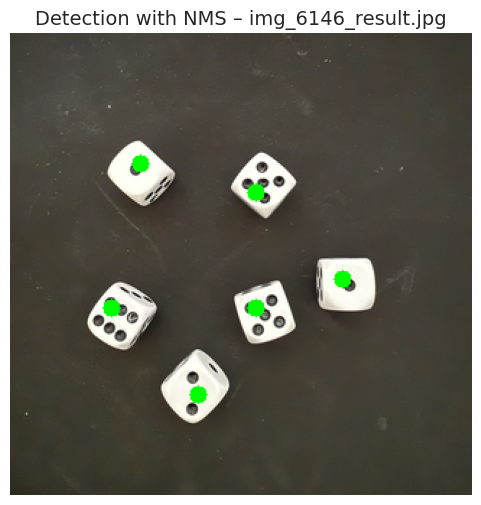

In [21]:
import os
import glob
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.ndimage import maximum_filter

# === Definice vlastních metrik ===
def f1_score(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    y_true = tf.cast(y_true, tf.float32)
    tp = tf.reduce_sum(y_true * y_pred)
    fp = tf.reduce_sum((1 - y_true) * y_pred)
    fn = tf.reduce_sum(y_true * (1 - y_pred))
    precision = tp / (tp + fp + tf.keras.backend.epsilon())
    recall = tp / (tp + fn + tf.keras.backend.epsilon())
    return 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())

def precision_m(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    y_true = tf.cast(y_true, tf.float32)
    tp = tf.reduce_sum(y_true * y_pred)
    fp = tf.reduce_sum((1 - y_true) * y_pred)
    return tp / (tp + fp + tf.keras.backend.epsilon())

def recall_m(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    y_true = tf.cast(y_true, tf.float32)
    tp = tf.reduce_sum(y_true * y_pred)
    fn = tf.reduce_sum(y_true * (1 - y_pred))
    return tp / (tp + fn + tf.keras.backend.epsilon())

def iou_m(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    y_true = tf.cast(y_true, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(tf.cast(tf.math.logical_or(tf.cast(y_true, tf.bool),
                                                     tf.cast(y_pred, tf.bool)), tf.float32))
    return intersection / (union + tf.keras.backend.epsilon())

# === Cesty ===
DATA_DIR = '/Volumes/DataHD/Tmp/PythonProjects/Book/TFlite/Dataset/Dice/val'
MODEL_DIR = '/Volumes/DataHD/Tmp/PythonProjects/Book/TFlite/Model'

# === Parametry ===
IMG_SIZE = (128, 128)
GRID_SIZE = (16, 16)
CELL_WIDTH = IMG_SIZE[0] // GRID_SIZE[0]
CELL_HEIGHT = IMG_SIZE[1] // GRID_SIZE[1]
THRESHOLD = 0.35
NMS_SIZE = 3

# === Načti model s vlastními metrikami ===
model = tf.keras.models.load_model(
    os.path.join(MODEL_DIR, 'fomo_detector_tf'),
    custom_objects={
        'f1_score': f1_score,
        'precision_m': precision_m,
        'recall_m': recall_m,
        'iou_m': iou_m
    }
)

# === Funkce na výběr náhodného obrázku ===
def load_random_image():
    image_files = glob.glob(os.path.join(DATA_DIR, '*.jpg'))
    img_path = np.random.choice(image_files)
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, IMG_SIZE) / 255.0
    return img_rgb, np.expand_dims(img_resized.astype(np.float32), axis=0), os.path.basename(img_path)

# === Non-Maximum Suppression ===
def apply_nms(pred_map, threshold=0.4, size=3):
    mask = pred_map > threshold
    maxima = (pred_map == maximum_filter(pred_map, size=size))
    coords = np.argwhere(mask & maxima)
    return coords

# === Načtení obrázku a predikce ===
orig_img, input_img, img_name = load_random_image()
h_orig, w_orig = orig_img.shape[:2]

pred = model.predict(input_img)[0].squeeze()
grid_h, grid_w = pred.shape

scale_x = w_orig / grid_w
scale_y = h_orig / grid_h

# === Aplikuj NMS ===
detections = apply_nms(pred, threshold=THRESHOLD, size=NMS_SIZE)

# === Vykreslení výstupu ===
for (y, x) in detections:
    cx = int((x + 0.5) * scale_x)
    cy = int((y + 0.5) * scale_y)
    cv2.circle(orig_img, (cx, cy), 6, (0, 255, 0), -1)

# === Zobraz ===
plt.figure(figsize=(6, 6))
plt.imshow(orig_img)
plt.title(f"Detection with NMS – {img_name}")
plt.axis('off')
plt.show()


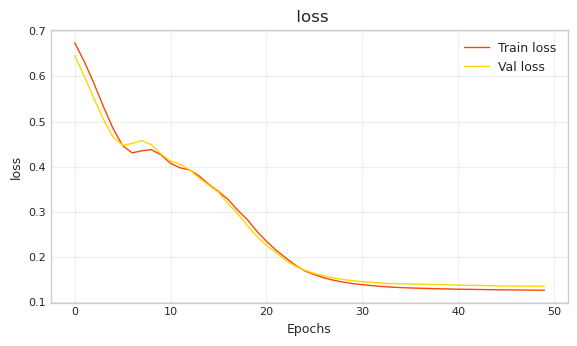

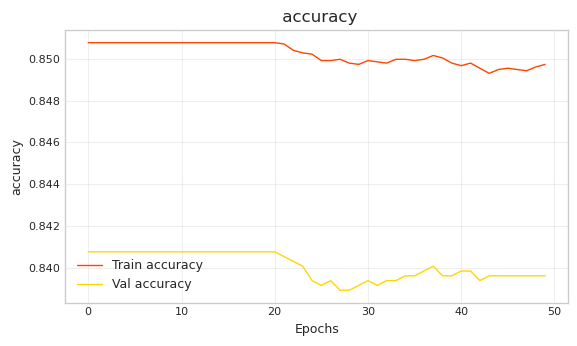

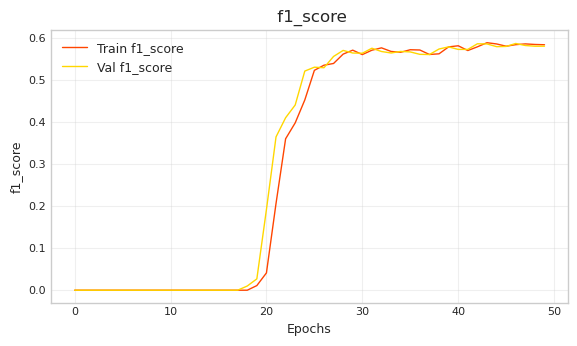

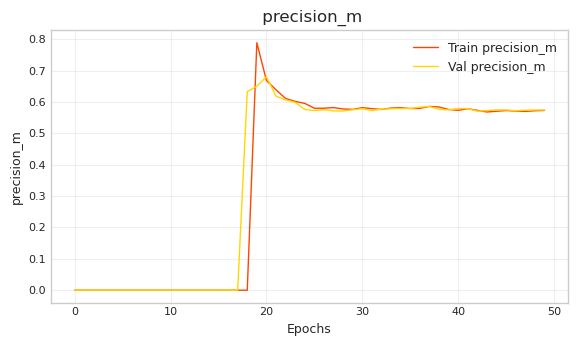

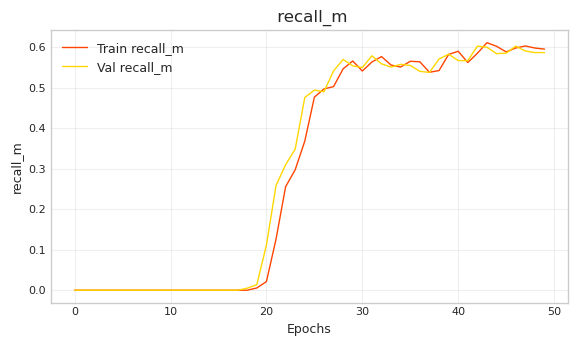

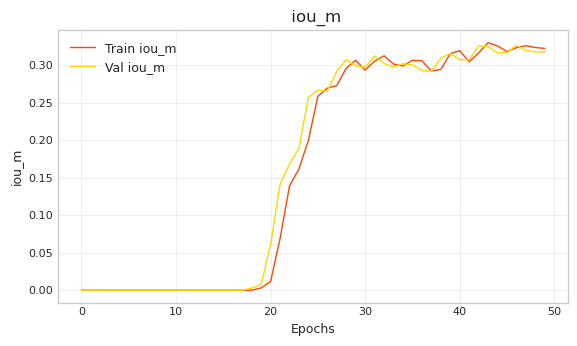

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Cesta k CSV logu
MODEL_DIR = '/Volumes/DataHD/Tmp/PythonProjects/Book/TFlite/Model'
LOG_PATH = os.path.join(MODEL_DIR, 'fomo_training_log.csv')

# Styl grafu
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'legend.fontsize': 9,
    'axes.labelsize': 9,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'lines.linewidth': 1,
    'font.family': 'DejaVu Sans',
})

# Načtení CSV logu
df = pd.read_csv(LOG_PATH)

# Seznam metrik k vykreslení
metrics_to_plot = ['loss', 'accuracy', 'f1_score', 'precision_m', 'recall_m', 'iou_m']

# Vykreslení metrik
for metric in metrics_to_plot:
    val_metric = 'val_' + metric
    if metric in df.columns or val_metric in df.columns:
        plt.figure(figsize=(6, 4))

        if metric in df.columns:
            plt.plot(df['epoch'], df[metric], label=f'Train {metric}', color='orangered')

        if val_metric in df.columns:
            plt.plot(df['epoch'], df[val_metric], label=f'Val {metric}', color='gold')

        plt.xlabel('Epochs')
        plt.ylabel(metric)
        plt.title(f' {metric}', fontsize=12)
        plt.grid(alpha=0.3)
        plt.legend(frameon=False)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
    else:
        print(f"⚠️ Metrika '{metric}' ani '{val_metric}' nebyla nalezena v CSV logu.")


# Zobrazení heatmapy

1/1 [==============================] - 0s 17ms/step


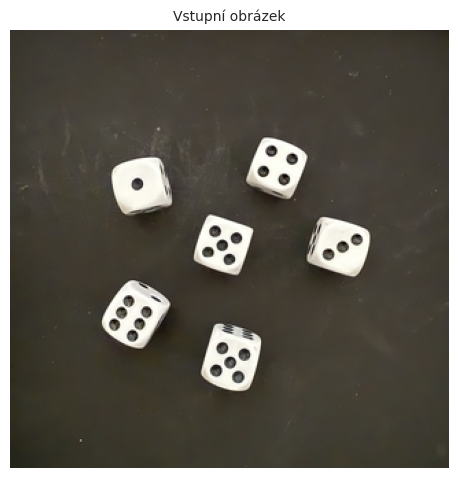

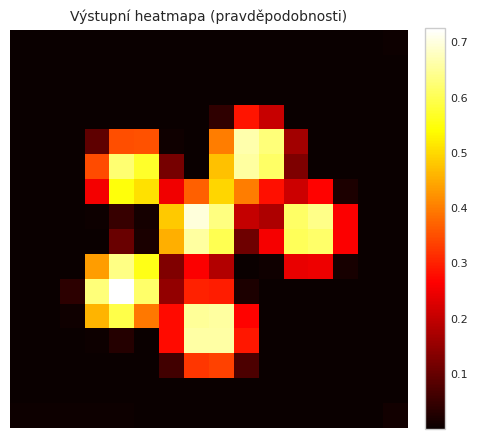

In [120]:
import os
import glob
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt

# Cesty
DATA_DIR = '/Volumes/DataHD/Tmp/PythonProjects/Book/TFlite/Dataset/Dice/val'
MODEL_DIR = '/Volumes/DataHD/Tmp/PythonProjects/Book/TFlite/Model'
MODEL_PATH = os.path.join(MODEL_DIR, 'fomo_detector_tf')

# Parametry
IMG_SIZE = (128, 128)
GRID_SIZE = (16, 16)

# Načtení modelu
model = tf.keras.models.load_model(MODEL_PATH, compile=False)

# Načti náhodný obrázek
image_files = glob.glob(os.path.join(DATA_DIR, '*.jpg'))
img_path = np.random.choice(image_files)
img_bgr = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
img_resized = cv2.resize(img_rgb, IMG_SIZE) / 255.0
input_tensor = np.expand_dims(img_resized.astype(np.float32), axis=0)

# Předpověď a výstupní mapa
pred_map = model.predict(input_tensor)[0].squeeze()

# === Zobrazení vstupního obrázku ===
plt.figure(figsize=(5, 5))
plt.imshow(img_rgb)
plt.title("Vstupní obrázek")
plt.axis('off')
plt.tight_layout()
plt.show()

# === Zobrazení heatmapy ===
plt.figure(figsize=(5, 5))
im = plt.imshow(pred_map, cmap='hot', interpolation='nearest',
                extent=(0, IMG_SIZE[0], IMG_SIZE[1], 0), aspect='equal')
plt.title("Výstupní heatmapa (pravděpodobnosti)")
plt.axis('off')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()


# Rozdělení dat na trénovací a testovací

In [ ]:
import os
import glob
import random
import shutil

# Nastavení cest
DATA_DIR = '/Volumes/DataHD/Tmp/PythonProjects/Book/TFlite/Dataset/Dice'
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
VAL_DIR = os.path.join(DATA_DIR, 'val')

# Vytvoření složek, pokud neexistují
os.makedirs(TRAIN_DIR, exist_ok=True)
os.makedirs(VAL_DIR, exist_ok=True)

# Najdi všechny obrázky
image_paths = glob.glob(os.path.join(DATA_DIR, '*.jpg'))
print(f"Celkem nalezeno {len(image_paths)} obrázků.")

# Zamíchej náhodně
random.shuffle(image_paths)

# Vypočítej split index
split_idx = int(0.8 * len(image_paths))
train_images = image_paths[:split_idx]
val_images = image_paths[split_idx:]

# Funkce pro přesun obrázku a txt souboru
def move_image_and_label(img_path, destination_dir):
    base_name = os.path.splitext(os.path.basename(img_path))[0]
    txt_path = os.path.join(DATA_DIR, f"{base_name}.txt")

    shutil.copy(img_path, os.path.join(destination_dir, os.path.basename(img_path)))

    if os.path.exists(txt_path):
        shutil.copy(txt_path, os.path.join(destination_dir, os.path.basename(txt_path)))

# Přesun trénovací sady
for img_path in train_images:
    move_image_and_label(img_path, TRAIN_DIR)

# Přesun validační sady
for img_path in val_images:
    move_image_and_label(img_path, VAL_DIR)

print(f"✅ Přesun dokončen: {len(train_images)} trénovacích a {len(val_images)} validačních obrázků.")


# Znázornění situací při učení modelu

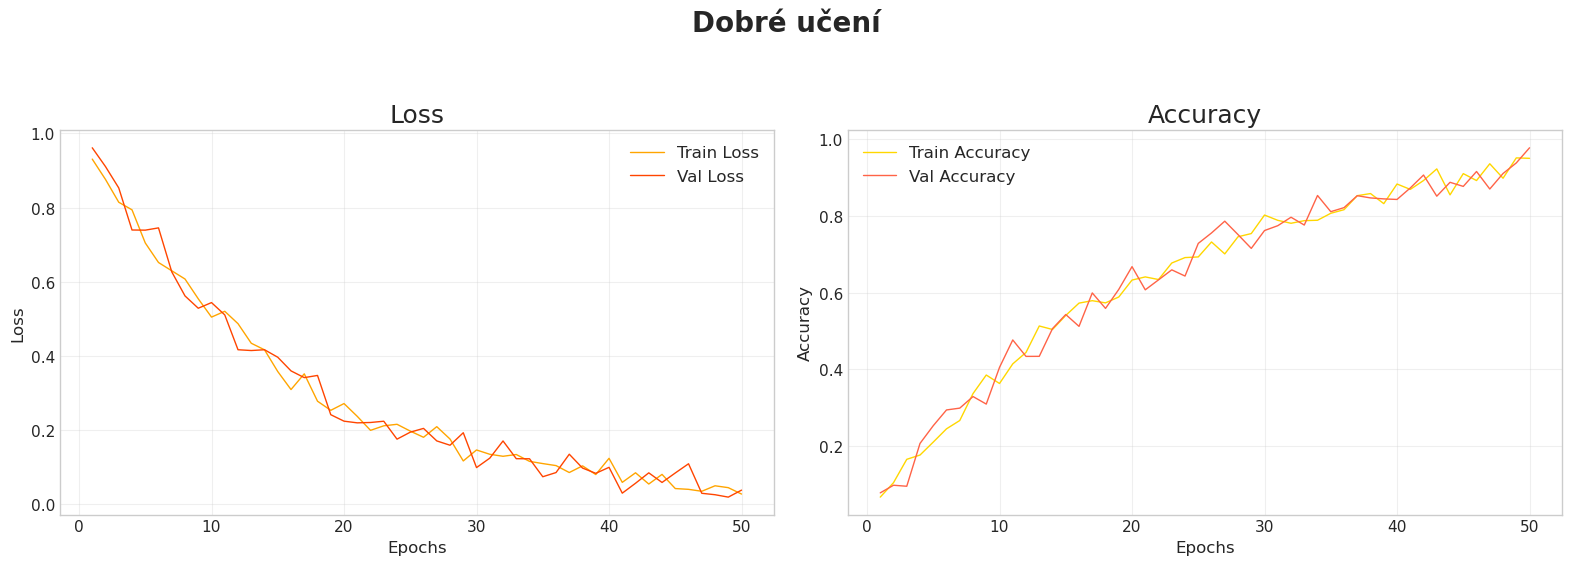

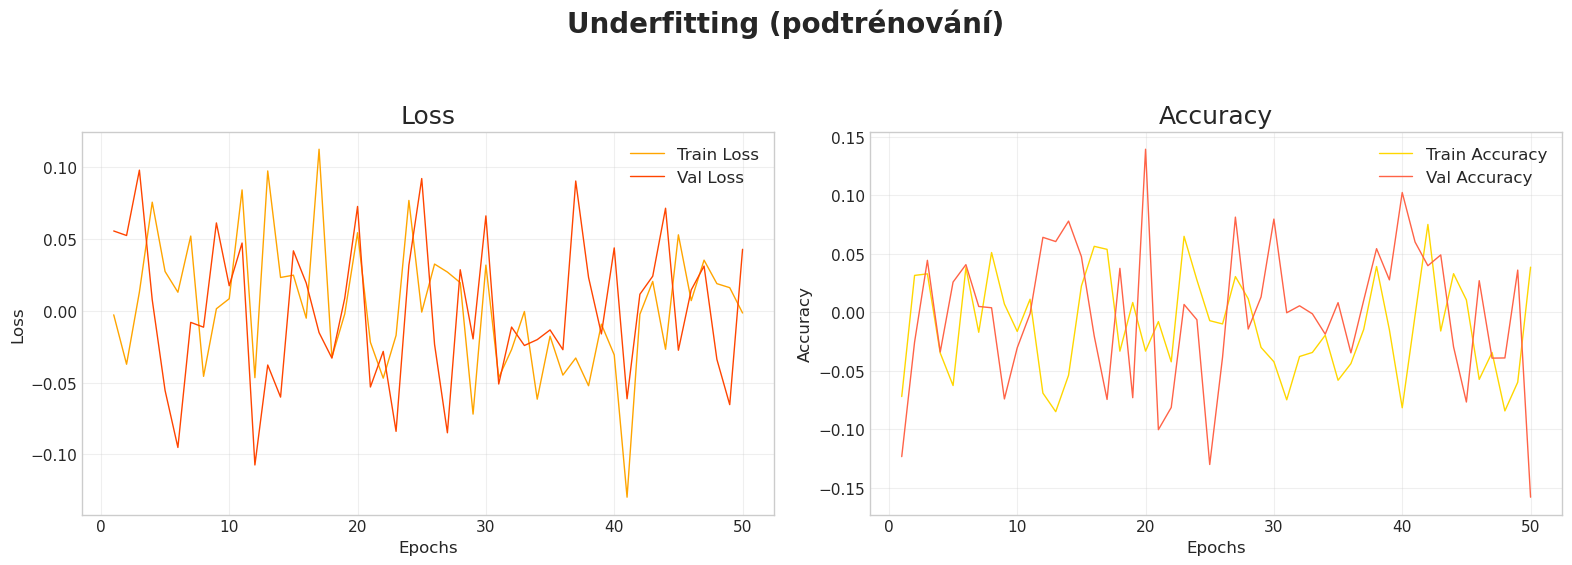

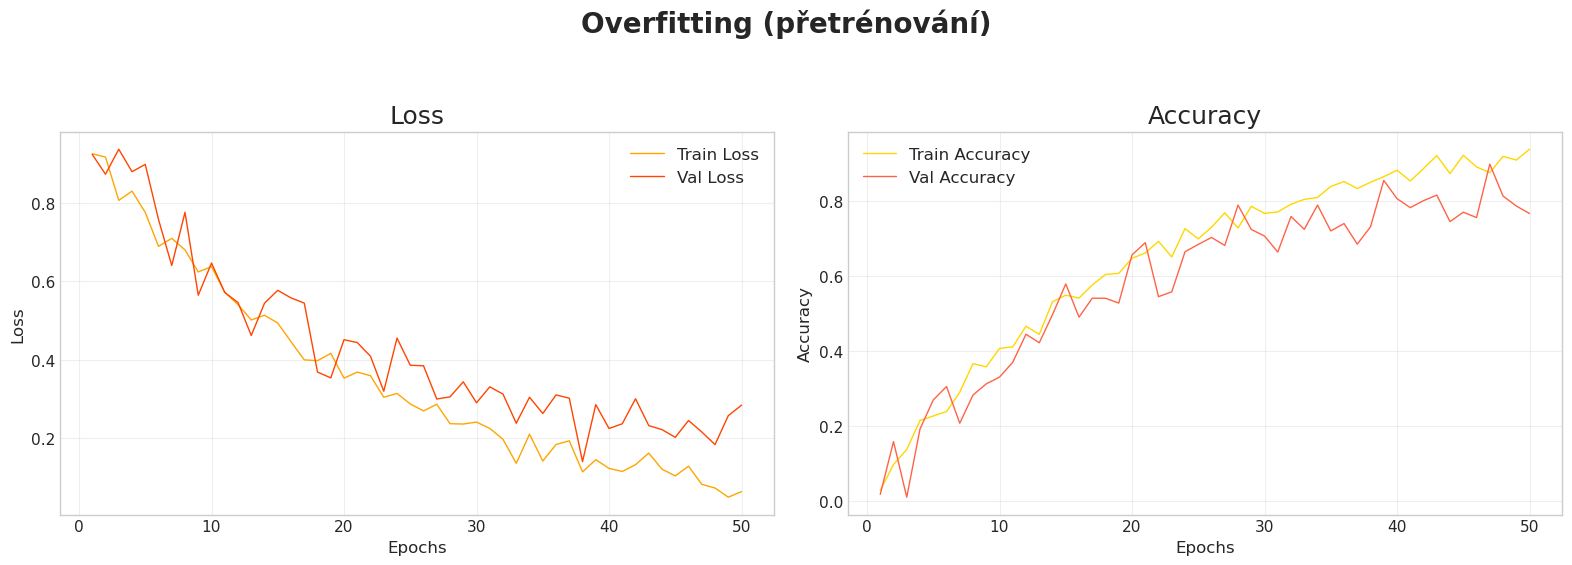

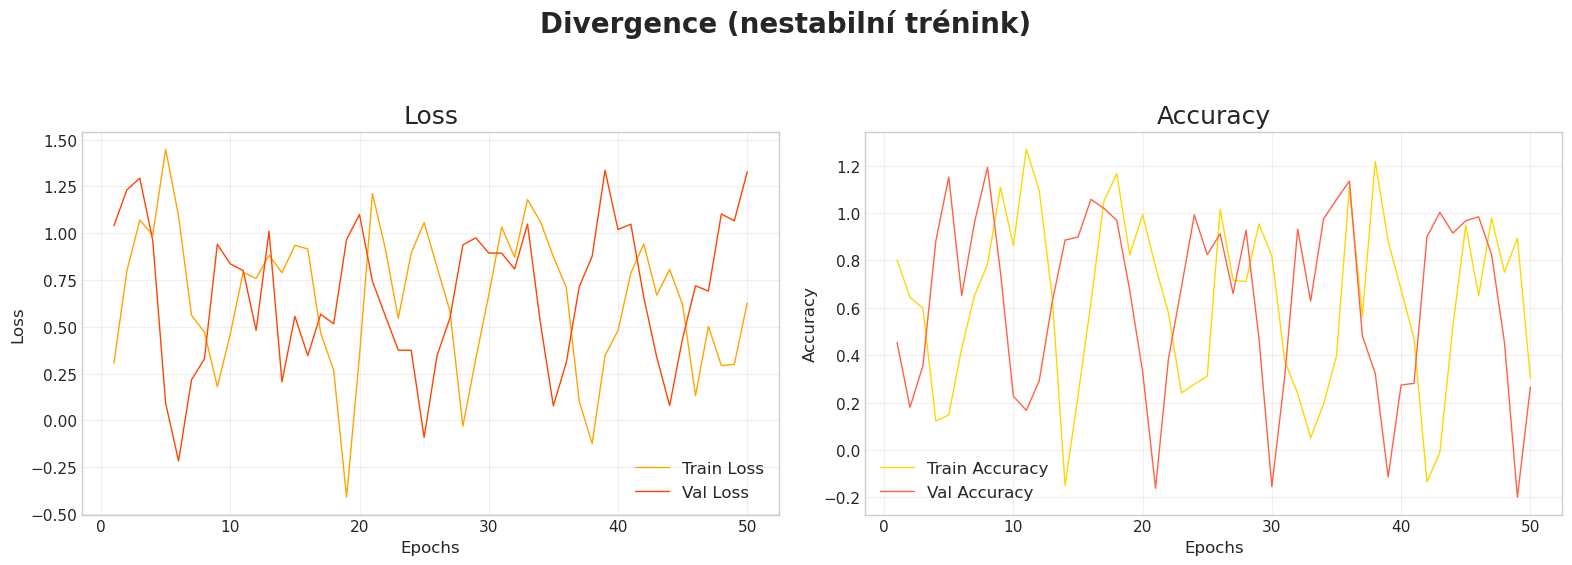

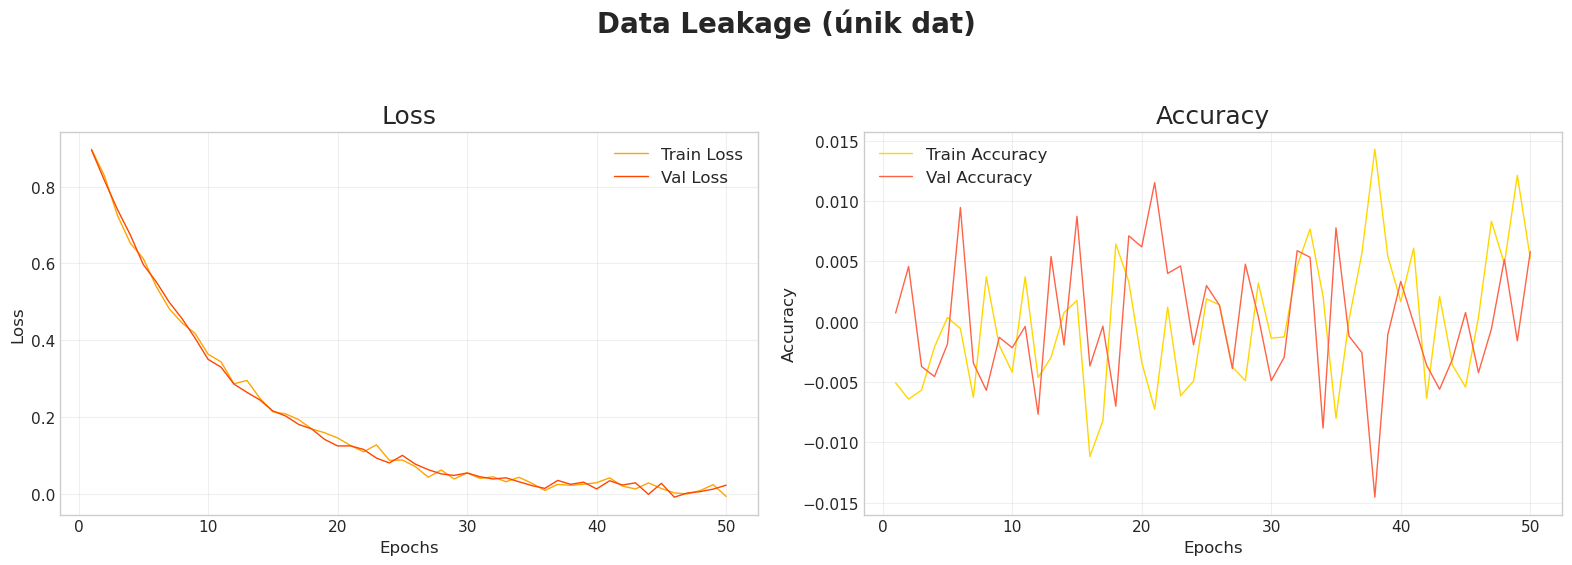

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Nastavení stylu
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.size': 16,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'legend.fontsize': 12,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'lines.linewidth': 1,
    'font.family': 'DejaVu Sans',
})

# Simulace epoch
epochs = np.arange(1, 51)

# Dobré učení
train_loss_good = np.exp(-epochs/15) + np.random.normal(0, 0.02, size=epochs.shape)
val_loss_good = np.exp(-epochs/15) + np.random.normal(0, 0.03, size=epochs.shape)
train_acc_good = 1 - np.exp(-epochs/20) + np.random.normal(0, 0.02, size=epochs.shape)
val_acc_good = 1 - np.exp(-epochs/20) + np.random.normal(0, 0.03, size=epochs.shape)

# Underfitting
train_loss_under = np.full_like(epochs, 0.8) + np.random.normal(0, 0.05, size=epochs.shape)
val_loss_under = np.full_like(epochs, 0.9) + np.random.normal(0, 0.05, size=epochs.shape)
train_acc_under = np.full_like(epochs, 0.5) + np.random.normal(0, 0.05, size=epochs.shape)
val_acc_under = np.full_like(epochs, 0.5) + np.random.normal(0, 0.05, size=epochs.shape)

# Overfitting
train_loss_over = np.exp(-epochs/20) + np.random.normal(0, 0.02, size=epochs.shape)
val_loss_over = np.exp(-epochs/20) + 0.03 * epochs/10 + np.random.normal(0, 0.05, size=epochs.shape)
train_acc_over = 1 - np.exp(-epochs/20) + np.random.normal(0, 0.02, size=epochs.shape)
val_acc_over = 1 - np.exp(-epochs/20) - 0.02 * epochs/10 + np.random.normal(0, 0.05, size=epochs.shape)

# Divergence
train_loss_div = np.abs(np.sin(epochs/3)) + np.random.normal(0, 0.2, size=epochs.shape)
val_loss_div = np.abs(np.sin(epochs/3 + 1)) + np.random.normal(0, 0.2, size=epochs.shape)
train_acc_div = np.abs(np.cos(epochs/3)) + np.random.normal(0, 0.2, size=epochs.shape)
val_acc_div = np.abs(np.cos(epochs/3 + 1)) + np.random.normal(0, 0.2, size=epochs.shape)

# Data leakage
train_loss_leak = np.exp(-epochs/10) + np.random.normal(0, 0.01, size=epochs.shape)
val_loss_leak = np.exp(-epochs/10) + np.random.normal(0, 0.01, size=epochs.shape)
train_acc_leak = np.full_like(epochs, 0.99) + np.random.normal(0, 0.005, size=epochs.shape)
val_acc_leak = np.full_like(epochs, 0.99) + np.random.normal(0, 0.005, size=epochs.shape)

# Funkce pro vykreslení
def plot_training(title, train_loss, val_loss, train_acc, val_acc):
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(title, fontsize=20, fontweight='bold')

    axs[0].plot(epochs, train_loss, label="Train Loss", color='orange')
    axs[0].plot(epochs, val_loss, label="Val Loss", color='orangered')
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Loss")
    axs[0].set_title("Loss", fontsize=18)
    axs[0].legend(frameon=False)
    axs[0].grid(alpha=0.3)

    axs[1].plot(epochs, train_acc, label="Train Accuracy", color='gold')
    axs[1].plot(epochs, val_acc, label="Val Accuracy", color='tomato')
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("Accuracy")
    axs[1].set_title("Accuracy", fontsize=18)
    axs[1].legend(frameon=False)
    axs[1].grid(alpha=0.3)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Vykreslení grafů
plot_training("Dobré učení", train_loss_good, val_loss_good, train_acc_good, val_acc_good)
plot_training("Underfitting (podtrénování)", train_loss_under, val_loss_under, train_acc_under, val_acc_under)
plot_training("Overfitting (přetrénování)", train_loss_over, val_loss_over, train_acc_over, val_acc_over)
plot_training("Divergence (nestabilní trénink)", train_loss_div, val_loss_div, train_acc_div, val_acc_div)
plot_training("Data Leakage (únik dat)", train_loss_leak, val_loss_leak, train_acc_leak, val_acc_leak)
